# Antarctic subglacial lake inventory

Investigate the inferred basal thermal conditions of RES-derived subglacial lakes

## Part 1: By visual inspection

Plot subglacial lakes, coloured by the type of observation used to inventory the lake, overlaid on a map of inferred basal temperature. Add Antarctic coastlines and grounding line for context.

In [20]:
# File path manipulation
import os

# Reading shapefiles and handle projections
import fiona
from pyproj import Proj, transform, Transformer
from shapely.geometry import shape

# General plotting
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.gridspec import GridSpec
import cmocean
import numpy as np
import scipy.interpolate

# Data management
import pandas as pd
import netCDF4 as nc
from IPython.display import display, Markdown

# Convert K to C
KtoC = -273.15

# Thresholds for cold and warm classificaiton
cold_threshold = -1.0   # See MacGregor et al. (2022) https://doi.org/10.5194/tc-16-3033-2022
cold_bias = -0.5
warm_bias = -1.5
warm_threshold = 0.0
extrm_threshold = -10.0

Now use `fiona` and `shapefile.geometry.shape` to read the grounding line and coastline. The grounding line is a `shapely.MultiPolygon` instance, while the coastline is a `shapely.Polygon` instance.

In [2]:
antarctic_dir = '../../data/raw/antarctic_geometry'
antarctic_gl_file = os.path.join(antarctic_dir, 'GroundingLine_Antarctica_v02.shp')
antarctic_cl_file = os.path.join(antarctic_dir, 'Coastline_Antarctica_v02.shp')

# Open the shapefile
with fiona.open(antarctic_gl_file) as shapefile:
    # Iterate over the records
    for record in shapefile:
        # Get the geometry from the record
        antarctic_gl = shape(record['geometry'])

with fiona.open(antarctic_cl_file) as shapefile:
    # Iterate over the records
    for record in shapefile:
        # Get the geometry from the record
        antarctic_cl = shape(record['geometry'])
    ps_proj = shapefile.crs # Antarctic polar stereographic projection data

### Basal thermal state

These outputs have already been processed from the raw ISSM outputs to gridded fields saved as portable `.nc` files.    

In [3]:
ISSM_output_dir = '../../data/generated/antarctic_thermal_state/'
ISSM_output_file = 'Antarctica_Transient_Ctrl_100yrs.nc'

xy_fname = os.path.join(ISSM_output_dir, 'xy.nc')
with nc.Dataset(xy_fname) as xy_nc:
    x = xy_nc['x'][:].data.T
    y = xy_nc['y'][:].data.T
    
ISSM_output_path = os.path.join(ISSM_output_dir, ISSM_output_file)
with nc.Dataset(ISSM_output_path) as Tm_nc:
    BasalTemp = Tm_nc['Tm'][:].T + KtoC

### Subglacial lake inventory

Subglacial lake inventory from [Livingstone et al. (2022)](https://doi.org/10.1038/s43017-021-00246-9), with an additional field to declare the type of observation.

Legend:

Label | Observation type
----- | ----------------
  0   |  Active lake
  1   |  RES only
  2   |  RES with flat ice surface
  3   |  Seismic
  4   |  Drilled

In [4]:
# Read raw data and coordinate projection
antarctic_lake_file = os.path.join('../../data/raw/lakes/','43017_2021_246_MOESM1_ESM_SK_Antarctica.csv')
antarctic_obstype = np.loadtxt(antarctic_lake_file, skiprows=1, delimiter=',', dtype=int, usecols=(3,), comments=None)
antarctic_latlon = np.loadtxt(antarctic_lake_file, skiprows=1, delimiter=',', dtype=str, usecols=(1,2), comments=None)

# Parse latlon to xy coordinates
src_crs = Proj('EPSG:4326') # WGS84
prj_crs = Proj(ps_proj) # Antarctic polar stereographic
transformer = Transformer.from_proj(src_crs, prj_crs)
antarctic_xy = np.zeros(antarctic_latlon.shape, dtype=float)
for i,xy in enumerate(antarctic_latlon):
    try:
        antarctic_xy[i] = transformer.transform(*xy.astype(float))
    except:
        antarctic_xy[i] = np.nan

In [5]:
# Re-encode observation types

# Convert integer flags to string labels
obstype_str = np.zeros(antarctic_obstype.shape, dtype='U8')
obstype_str[antarctic_obstype==1] = 'RES_only'
obstype_str[antarctic_obstype==2] = 'RES_flat'
obstype_str[antarctic_obstype==3] = 'seismic'
obstype_str[antarctic_obstype==4] = 'drilled'
obstype_str[antarctic_obstype==0] = 'active'

# Convert to pd.DataFrame for nice summary printing
lakes_df = pd.DataFrame(
    data={'obs': obstype_str,
          'x': antarctic_xy[:, 0],
          'y': antarctic_xy[:, 1]})
lakes_df['obs'] = lakes_df['obs'].astype('category')

stable_lakes = lakes_df.where(lakes_df['obs']!='active')

print('Summary of lake observation types')
print(stable_lakes['obs'].value_counts(normalize=False))
print(stable_lakes['obs'].value_counts(normalize=True))

# Count number of each lake observation type
count_RES = stable_lakes.where(stable_lakes['obs']=='RES_only').count()['obs']
count_RES_flat = stable_lakes.where(stable_lakes['obs']=='RES_flat').count()['obs']
count_seismic = stable_lakes.where(stable_lakes['obs']=='seismic').count()['obs']

lake_counts = {'RES_only': count_RES, 'RES_flat':count_RES_flat, 'seismic':count_seismic}


stable_lakes

Summary of lake observation types
obs
RES_only    523
RES_flat      6
seismic       5
active        0
Name: count, dtype: int64
obs
RES_only    0.979401
RES_flat    0.011236
seismic     0.009363
active      0.000000
Name: proportion, dtype: float64


,obs,x,y
0,RES_only,1.297000e+06,3.396313e+04
1,seismic,1.250803e+06,-3.234797e+05
2,RES_only,1.203517e+06,-8.364664e+05
3,RES_only,7.064692e+05,-1.687215e+06
4,RES_only,1.218055e+06,-6.827020e+05
...,...,...,...
671,RES_only,1.345845e+06,-8.278077e+05
672,RES_only,1.341964e+06,-7.949639e+05
673,RES_only,1.192875e+06,-3.714707e+05
674,RES_only,1.980595e+05,-9.461808e+04


### Overlay lake positions and basal thermal state

In [6]:
# Scatter plot settings
colors = {
    'RES_only': '#d01616',
    'RES_flat': '#ff00ff',
    'seismic' : '#00ffff',
    'drilled' : 'blue',
    'active'  : '#ffffff00',
    'grounding_line': 'k',
    'coastline': 'k',
}

edgecolor = {
    'RES_only': 'k',
    'RES_flat': 'k',
    'seismic': 'k'
}

markers = {
    'RES_only': 'o',
    'RES_flat': '^',
    'seismic': 's',
}

size = {
    'RES_only': 30,
    'RES_flat': 60,
    'seismic': 60
}
labels = {'RES_only': 'RES only',
          'RES_flat': 'RES, flat',
          'seismic': 'Seismic',
          'drilled': 'Drilled',
         }

### Plot lakes over modelled basal temperature and over classified basal thermal state

(-2508074.680726347, -2143924.7933013136, 2675676.101441902, 2190324.7645620583)


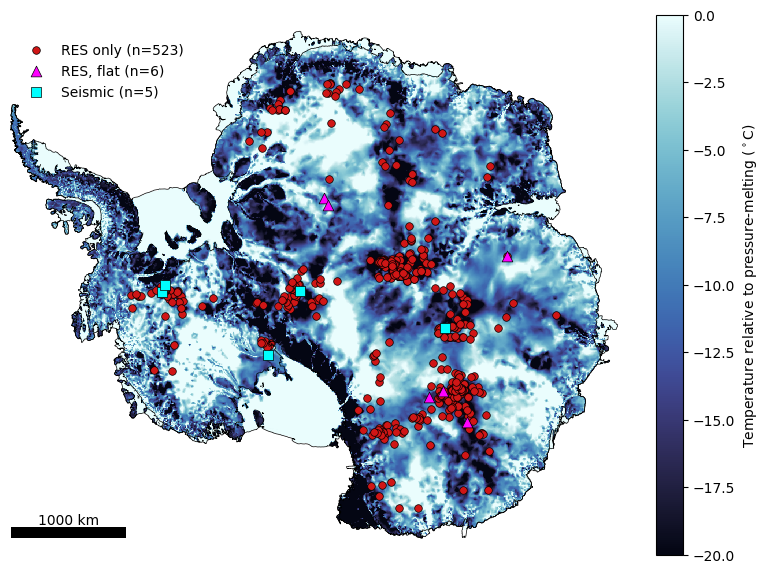

In [7]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='w')

# Thermal state
pc = ax.pcolormesh(x, y, BasalTemp, vmin=-20, vmax=0, cmap=cmocean.cm.ice)
cb = fig.colorbar(pc)
cb.set_label(r'Temperature relative to pressure-melting ($^\circ$C)')

# Grounding line and coastline
for gl in antarctic_gl.geoms:
    ax.plot(gl.exterior.coords.xy[0], gl.exterior.coords.xy[1], color=colors['grounding_line'], linewidth=0.5)
ax.plot(antarctic_cl.exterior.coords.xy[0], antarctic_cl.exterior.coords.xy[1], color=colors['coastline'], linewidth=0.5)

# Lake inventory
# lakes_categories = stable_lakes['obs'].values.categories
lakes_categories = ['RES_only', 'RES_flat', 'seismic']
for category in lakes_categories:
    if category!='active':
        lakes_subset = stable_lakes.where(stable_lakes['obs']==category)
        ax.scatter(lakes_subset['x'], lakes_subset['y'], size[category],
                   color=colors[category], edgecolor=edgecolor[category], linewidth=0.5, 
                   label=labels[category] + ' (n={:n})'.format(lake_counts[category]), 
                   marker=markers[category])

# Axes controls
ax.set_aspect('equal')
ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper left', frameon=False, markerscale=1)

# Scalebar
gl_bounds = antarctic_gl.bounds
print(gl_bounds)
scale_width = 1e6
scale_height = 0.1e6
scalebar = patches.Rectangle((gl_bounds[0], gl_bounds[1]), scale_width, scale_height, facecolor='k')
ax.add_patch(scalebar)
ax.text(gl_bounds[0] + 0.5*scale_width, gl_bounds[1] + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')

fig.subplots_adjust(left=0.05, right=1., bottom=0.05, top=0.95)
fig.savefig('antarctic_thermal_lakes.png', dpi=600)

#### Categorize basal thermal state

Categorize the thermal state as "Extreme", "Cold', and "Thawed'

(-2508074.680726347, -2143924.7933013136, 2675676.101441902, 2190324.7645620583)


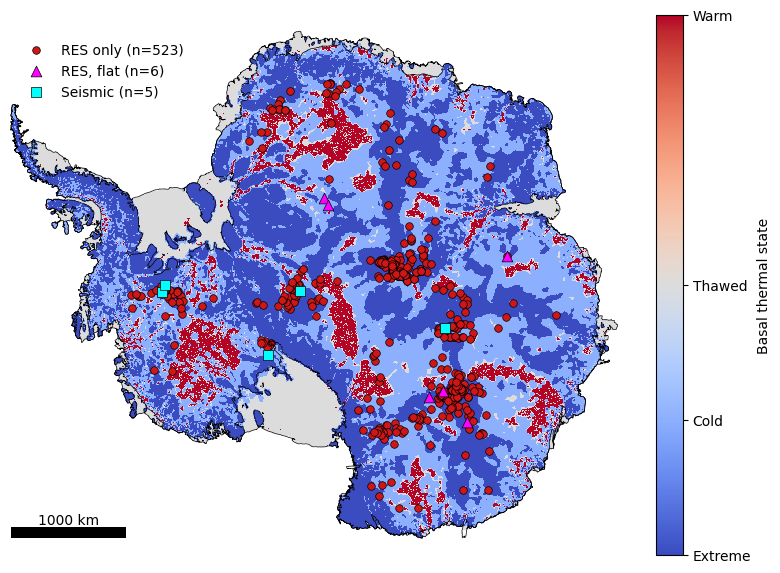

In [8]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='w')

BasalTemp_cat = BasalTemp.copy()
BasalTemp_cat[BasalTemp<extrm_threshold] = -2
BasalTemp_cat[BasalTemp>=extrm_threshold] = -1
BasalTemp_cat[BasalTemp>=cold_threshold] = 0
BasalTemp_cat[BasalTemp>=warm_threshold] = 2

# Thermal state
pc = ax.pcolormesh(x, y, BasalTemp_cat, vmin=-2, vmax=2, cmap='coolwarm')
cb = fig.colorbar(pc)
cb.set_label('Basal thermal state')
cb.set_ticks([-2, -1, 0, 2])
cb.set_ticklabels(['Extreme', 'Cold', 'Thawed', 'Warm'])

# Grounding line and coastline
for gl in antarctic_gl.geoms:
    ax.plot(gl.exterior.coords.xy[0], gl.exterior.coords.xy[1], color=colors['grounding_line'], linewidth=0.5)
ax.plot(antarctic_cl.exterior.coords.xy[0], antarctic_cl.exterior.coords.xy[1], color=colors['coastline'], linewidth=0.5)

# Lake inventory
# lakes_categories = stable_lakes['obs'].values.categories
lakes_categories = ['RES_only', 'RES_flat', 'seismic']
for category in lakes_categories:
    if category!='active':
        lakes_subset = stable_lakes.where(stable_lakes['obs']==category)
        ax.scatter(lakes_subset['x'], lakes_subset['y'], size[category],
                   color=colors[category], edgecolor=edgecolor[category], linewidth=0.5, 
                   label=labels[category] + ' (n={:n})'.format(lake_counts[category]), 
                   marker=markers[category])


# Axes controls
ax.set_aspect('equal')
ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper left', frameon=False, markerscale=1)

# Scalebar
gl_bounds = antarctic_gl.bounds
print(gl_bounds)
scale_width = 1e6
scale_height = 0.1e6
scalebar = patches.Rectangle((gl_bounds[0], gl_bounds[1]), scale_width, scale_height, facecolor='k')
ax.add_patch(scalebar)
ax.text(gl_bounds[0] + 0.5*scale_width, gl_bounds[1] + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')

fig.subplots_adjust(left=0.05, right=1., bottom=0.05, top=0.95)
fig.savefig('antarctic_thermal_cat_lakes.png', dpi=600)

**Note**: Change colourbar above to a simple legend

#### Highlight areas that are between the "extreme" and "cold" thresholds (-10 to -1 C)

(-2508074.680726347, -2143924.7933013136, 2675676.101441902, 2190324.7645620583)


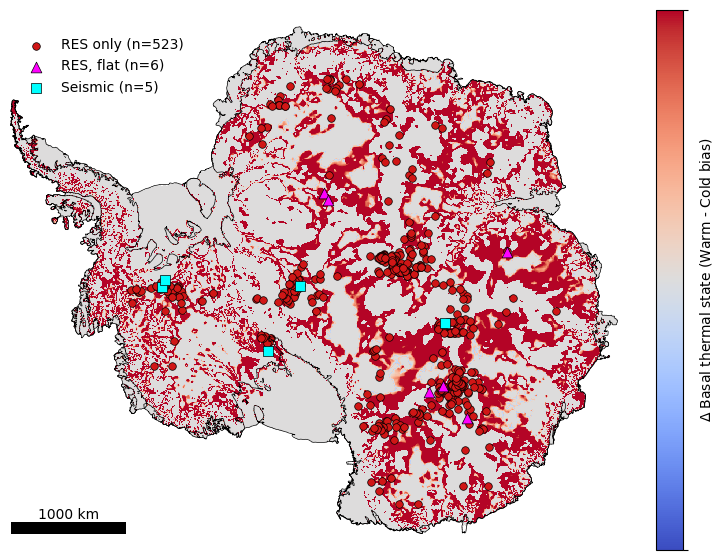

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

BasalTemp_cold = BasalTemp.copy()
BasalTemp_cold[BasalTemp<extrm_threshold] = -2
BasalTemp_cold[BasalTemp>=cold_threshold] = -1
BasalTemp_cold[BasalTemp>=warm_threshold] = 0

BasalTemp_warm = BasalTemp.copy()
BasalTemp_warm[BasalTemp<warm_bias] = -2
BasalTemp_warm[BasalTemp>=warm_bias] = -1
BasalTemp_warm[BasalTemp>=warm_threshold] = 0

delta_BasalTemp = BasalTemp_warm - BasalTemp_cold

# Thermal state
pc = ax.pcolormesh(x, y, delta_BasalTemp, vmin=-2, vmax=2, cmap='coolwarm')
cb = fig.colorbar(pc)
cb.set_label(r'$\Delta$ Basal thermal state (Warm - Cold bias)')
cb.set_ticks([-2, 2])
cb.set_ticklabels(['', ''])

# Grounding line and coastline
for gl in antarctic_gl.geoms:
    ax.plot(gl.exterior.coords.xy[0], gl.exterior.coords.xy[1], color=colors['grounding_line'], linewidth=0.5)
ax.plot(antarctic_cl.exterior.coords.xy[0], antarctic_cl.exterior.coords.xy[1], color=colors['coastline'], linewidth=0.5)

# Lake inventory
# lakes_categories = stable_lakes['obs'].values.categories
lakes_categories = ['RES_only', 'RES_flat', 'seismic']
for category in lakes_categories:
    if category!='active':
        lakes_subset = stable_lakes.where(stable_lakes['obs']==category)
        ax.scatter(lakes_subset['x'], lakes_subset['y'], size[category],
                   color=colors[category], edgecolor=edgecolor[category], linewidth=0.5, 
                   label=labels[category] + ' (n={:n})'.format(lake_counts[category]), 
                   marker=markers[category])


# Axes controls
ax.set_aspect('equal')
ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper left', frameon=False, markerscale=1)

# Scalebar
gl_bounds = antarctic_gl.bounds
print(gl_bounds)
scale_width = 1e6
scale_height = 0.1e6
scalebar = patches.Rectangle((gl_bounds[0], gl_bounds[1]), scale_width, scale_height, facecolor='k')
ax.add_patch(scalebar)
ax.text(gl_bounds[0] + 0.5*scale_width, gl_bounds[1] + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')

fig.subplots_adjust(left=0.05, right=1., bottom=0.05, top=0.95)

## Part 2: Analysis

Extract the inferred basal temperature for each subglacial lake position


In [10]:
xvec = x[0, :]
yvec = y[:, 0]
points = (yvec, xvec)
xq = stable_lakes[['y', 'x']].to_numpy()

lake_temp = scipy.interpolate.interpn(points, BasalTemp, xq, bounds_error=False, fill_value=np.nan)

stable_lakes['BasalTemp'] = lake_temp

stable_lakes

,obs,x,y,BasalTemp
0,RES_only,1.297000e+06,3.396313e+04,-0.553961
1,seismic,1.250803e+06,-3.234797e+05,-19.955869
2,RES_only,1.203517e+06,-8.364664e+05,-6.117854
3,RES_only,7.064692e+05,-1.687215e+06,-8.145979
4,RES_only,1.218055e+06,-6.827020e+05,-0.792647
...,...,...,...,...
671,RES_only,1.345845e+06,-8.278077e+05,-22.572520
672,RES_only,1.341964e+06,-7.949639e+05,-18.059177
673,RES_only,1.192875e+06,-3.714707e+05,-9.767415
674,RES_only,1.980595e+05,-9.461808e+04,-12.297284


Categorize the thermal state as "Cold", "Uncertain", or "Thawed" based on temperature thresholds from [MacGregor et al. (2022)](https://doi.org/10.5194/tc-16-3033-2022). Set the standard threshold at $-1^\circ {\rm{C}}$, with cold/warm biases using $-1.5^\circ {\rm{C}}$ and $-0.5^\circ {\rm{C}}$.

In [11]:
stable_lakes['BasalTemp_M22'] = pd.cut(stable_lakes['BasalTemp'], 
    bins=(-np.inf, cold_threshold, warm_threshold, np.inf), labels=('Cold', 'Uncertain', 'Thawed'))
stable_lakes['BasalTemp_M22_warmBias'] = pd.cut(stable_lakes['BasalTemp'], 
    bins=(-np.inf, warm_bias, warm_threshold, np.inf), labels=('Cold', 'Uncertain', 'Thawed'))
stable_lakes['BasalTemp_M22_coldBias'] = pd.cut(stable_lakes['BasalTemp'], 
    bins=(-np.inf, cold_bias, warm_threshold, np.inf), labels=('Cold', 'Uncertain', 'Thawed'))
stable_lakes['BasalTemp_cat'] = pd.cut(stable_lakes['BasalTemp'], 
    bins=(-np.inf, extrm_threshold, cold_threshold, np.inf), labels=('Extreme', 'Cold', 'Thawed'))
stable_lakes

,obs,x,y,BasalTemp,BasalTemp_M22,BasalTemp_M22_warmBias,BasalTemp_M22_coldBias,BasalTemp_cat
0,RES_only,1.297000e+06,3.396313e+04,-0.553961,Uncertain,Uncertain,Cold,Thawed
1,seismic,1.250803e+06,-3.234797e+05,-19.955869,Cold,Cold,Cold,Extreme
2,RES_only,1.203517e+06,-8.364664e+05,-6.117854,Cold,Cold,Cold,Cold
3,RES_only,7.064692e+05,-1.687215e+06,-8.145979,Cold,Cold,Cold,Cold
4,RES_only,1.218055e+06,-6.827020e+05,-0.792647,Uncertain,Uncertain,Cold,Thawed
...,...,...,...,...,...,...,...,...
671,RES_only,1.345845e+06,-8.278077e+05,-22.572520,Cold,Cold,Cold,Extreme
672,RES_only,1.341964e+06,-7.949639e+05,-18.059177,Cold,Cold,Cold,Extreme
673,RES_only,1.192875e+06,-3.714707e+05,-9.767415,Cold,Cold,Cold,Cold
674,RES_only,1.980595e+05,-9.461808e+04,-12.297284,Cold,Cold,Cold,Extreme


### Histogram of inferred basal state

Using these classifications, summarize the proportion of lakes in each state with a histogram and by number

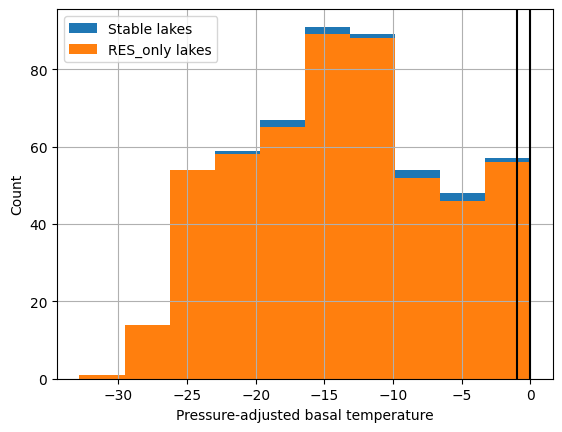

In [12]:
RES_only_lakes = stable_lakes[stable_lakes['obs']=='RES_only']
RES_flat_lakes = stable_lakes[stable_lakes['obs']=='RES_flat']
RES_lakes = stable_lakes[stable_lakes['obs']!='seismic']
seismic_lakes = stable_lakes[stable_lakes['obs']=='seismic']

fig, ax = plt.subplots()
ax.hist(stable_lakes['BasalTemp'], label='Stable lakes')

ax.hist(RES_only_lakes['BasalTemp'], label='RES_only lakes')
ax.set_xlabel('Pressure-adjusted basal temperature')
ax.set_ylabel('Count')
ax.axvline(cold_threshold, color='k')
ax.axvline(warm_threshold, color='k')
ax.legend()
ax.grid()

### Tables

Print the number and proportion of stable and RES lakes in each basal state

In [13]:
### Stable lakes

In [14]:
display(Markdown('**Counts**'))
print(stable_lakes['BasalTemp_cat'].value_counts(normalize=False, sort=False))

display(Markdown('**Normalized**'))
print(stable_lakes['BasalTemp_cat'].value_counts(normalize=True, sort=False))

stable_lakes

# display(Markdown('## Warm Bias'))
# display(Markdown('**Counts**'))
# print(stable_lakes['Tm_warmBias'].value_counts(normalize=False))
# display(Markdown('**Normalized**'))
# print(stable_lakes['Tm_warmBias'].value_counts(normalize=True))

# display(Markdown('## Cold Bias'))
# display(Markdown('**Counts**'))
# print(stable_lakes['Tm_coldBias'].value_counts(normalize=False))
# display(Markdown('**Normalized**'))
# print(stable_lakes['Tm_coldBias'].value_counts(normalize=True))


**Counts**

BasalTemp_cat
Extreme    371
Cold       133
Thawed      30
Name: count, dtype: int64


**Normalized**

BasalTemp_cat
Extreme    0.694757
Cold       0.249064
Thawed     0.056180
Name: proportion, dtype: float64


,obs,x,y,BasalTemp,BasalTemp_M22,BasalTemp_M22_warmBias,BasalTemp_M22_coldBias,BasalTemp_cat
0,RES_only,1.297000e+06,3.396313e+04,-0.553961,Uncertain,Uncertain,Cold,Thawed
1,seismic,1.250803e+06,-3.234797e+05,-19.955869,Cold,Cold,Cold,Extreme
2,RES_only,1.203517e+06,-8.364664e+05,-6.117854,Cold,Cold,Cold,Cold
3,RES_only,7.064692e+05,-1.687215e+06,-8.145979,Cold,Cold,Cold,Cold
4,RES_only,1.218055e+06,-6.827020e+05,-0.792647,Uncertain,Uncertain,Cold,Thawed
...,...,...,...,...,...,...,...,...
671,RES_only,1.345845e+06,-8.278077e+05,-22.572520,Cold,Cold,Cold,Extreme
672,RES_only,1.341964e+06,-7.949639e+05,-18.059177,Cold,Cold,Cold,Extreme
673,RES_only,1.192875e+06,-3.714707e+05,-9.767415,Cold,Cold,Cold,Cold
674,RES_only,1.980595e+05,-9.461808e+04,-12.297284,Cold,Cold,Cold,Extreme


### All RES lakes

The `RES_lakes` table includes `RES_only` and `RES_flat` (RES + hydraulically flat) labels.

In [15]:
display(Markdown('**Counts**'))
print(RES_lakes['BasalTemp_cat'].value_counts(normalize=False, sort=False))

display(Markdown('**Normalized**'))
print(RES_lakes['BasalTemp_cat'].value_counts(normalize=True, sort=False))

RES_lakes

# display(Markdown('## Warm Bias'))
# display(Markdown('**Counts**'))
# print(RES_lakes['Tm_warmBias'].value_counts(normalize=False))
# display(Markdown('**Normalized**'))
# print(RES_lakes['Tm_warmBias'].value_counts(normalize=True))

# display(Markdown('## Cold Bias'))
# display(Markdown('**Counts**'))
# print(RES_lakes['Tm_coldBias'].value_counts(normalize=False))
# display(Markdown('**Normalized**'))
# print(RES_lakes['Tm_coldBias'].value_counts(normalize=True))


**Counts**

BasalTemp_cat
Extreme    367
Cold       132
Thawed      30
Name: count, dtype: int64


**Normalized**

BasalTemp_cat
Extreme    0.693762
Cold       0.249527
Thawed     0.056711
Name: proportion, dtype: float64


,obs,x,y,BasalTemp,BasalTemp_M22,BasalTemp_M22_warmBias,BasalTemp_M22_coldBias,BasalTemp_cat
0,RES_only,1.297000e+06,3.396313e+04,-0.553961,Uncertain,Uncertain,Cold,Thawed
2,RES_only,1.203517e+06,-8.364664e+05,-6.117854,Cold,Cold,Cold,Cold
3,RES_only,7.064692e+05,-1.687215e+06,-8.145979,Cold,Cold,Cold,Cold
4,RES_only,1.218055e+06,-6.827020e+05,-0.792647,Uncertain,Uncertain,Cold,Thawed
5,RES_only,1.426302e+06,-9.994497e+05,-19.139441,Cold,Cold,Cold,Extreme
...,...,...,...,...,...,...,...,...
671,RES_only,1.345845e+06,-8.278077e+05,-22.572520,Cold,Cold,Cold,Extreme
672,RES_only,1.341964e+06,-7.949639e+05,-18.059177,Cold,Cold,Cold,Extreme
673,RES_only,1.192875e+06,-3.714707e+05,-9.767415,Cold,Cold,Cold,Cold
674,RES_only,1.980595e+05,-9.461808e+04,-12.297284,Cold,Cold,Cold,Extreme


### RES_only lakes


In [16]:
display(Markdown('**Counts**'))
print(RES_only_lakes['BasalTemp_cat'].value_counts(normalize=False, sort=False))

display(Markdown('**Normalized**'))
print(RES_only_lakes['BasalTemp_cat'].value_counts(normalize=True, sort=False))

RES_only_lakes

# display(Markdown('## Warm Bias'))
# display(Markdown('**Counts**'))
# print(RES_lakes['Tm_warmBias'].value_counts(normalize=False))
# display(Markdown('**Normalized**'))
# print(RES_lakes['Tm_warmBias'].value_counts(normalize=True))

# display(Markdown('## Cold Bias'))
# display(Markdown('**Counts**'))
# print(RES_lakes['Tm_coldBias'].value_counts(normalize=False))
# display(Markdown('**Normalized**'))
# print(RES_lakes['Tm_coldBias'].value_counts(normalize=True))


**Counts**

BasalTemp_cat
Extreme    365
Cold       128
Thawed      30
Name: count, dtype: int64


**Normalized**

BasalTemp_cat
Extreme    0.697897
Cold       0.244742
Thawed     0.057361
Name: proportion, dtype: float64


,obs,x,y,BasalTemp,BasalTemp_M22,BasalTemp_M22_warmBias,BasalTemp_M22_coldBias,BasalTemp_cat
0,RES_only,1.297000e+06,3.396313e+04,-0.553961,Uncertain,Uncertain,Cold,Thawed
2,RES_only,1.203517e+06,-8.364664e+05,-6.117854,Cold,Cold,Cold,Cold
3,RES_only,7.064692e+05,-1.687215e+06,-8.145979,Cold,Cold,Cold,Cold
4,RES_only,1.218055e+06,-6.827020e+05,-0.792647,Uncertain,Uncertain,Cold,Thawed
5,RES_only,1.426302e+06,-9.994497e+05,-19.139441,Cold,Cold,Cold,Extreme
...,...,...,...,...,...,...,...,...
671,RES_only,1.345845e+06,-8.278077e+05,-22.572520,Cold,Cold,Cold,Extreme
672,RES_only,1.341964e+06,-7.949639e+05,-18.059177,Cold,Cold,Cold,Extreme
673,RES_only,1.192875e+06,-3.714707e+05,-9.767415,Cold,Cold,Cold,Cold
674,RES_only,1.980595e+05,-9.461808e+04,-12.297284,Cold,Cold,Cold,Extreme


### RES_flat lakes

In [17]:
display(Markdown('**Counts**'))
print(RES_flat_lakes['BasalTemp_cat'].value_counts(normalize=False, sort=False))

display(Markdown('**Normalized**'))
print(RES_flat_lakes['BasalTemp_cat'].value_counts(normalize=True, sort=False))

RES_flat_lakes


**Counts**

BasalTemp_cat
Extreme    2
Cold       4
Thawed     0
Name: count, dtype: int64


**Normalized**

BasalTemp_cat
Extreme    0.333333
Cold       0.666667
Thawed     0.000000
Name: proportion, dtype: float64


,obs,x,y,BasalTemp,BasalTemp_M22,BasalTemp_M22_warmBias,BasalTemp_M22_coldBias,BasalTemp_cat
8,RES_flat,1.108192e+06,-9.200385e+05,-15.392903,Cold,Cold,Cold,Extreme
24,RES_flat,1.444053e+06,-1.142492e+06,-14.462539,Cold,Cold,Cold,Extreme
38,RES_flat,1.232152e+06,-8.685436e+05,-7.228026,Cold,Cold,Cold,Cold
227,RES_flat,2.039693e+05,8.013721e+05,-6.359885,Cold,Cold,Cold,Cold
228,RES_flat,2.420418e+05,7.392168e+05,-2.102334,Cold,Cold,Cold,Cold
519,RES_flat,1.785104e+06,2.942419e+05,-4.249665,Cold,Cold,Cold,Cold


### Seismic lakes

In [18]:
display(Markdown('**Counts**'))
print(seismic_lakes['BasalTemp_cat'].value_counts(normalize=False, sort=False))

display(Markdown('**Normalized**'))
print(seismic_lakes['BasalTemp_cat'].value_counts(normalize=True, sort=False))

seismic_lakes


**Counts**

BasalTemp_cat
Extreme    4
Cold       1
Thawed     0
Name: count, dtype: int64


**Normalized**

BasalTemp_cat
Extreme    0.8
Cold       0.2
Thawed     0.0
Name: proportion, dtype: float64


,obs,x,y,BasalTemp,BasalTemp_M22,BasalTemp_M22_warmBias,BasalTemp_M22_coldBias,BasalTemp_cat
1,seismic,1.250803e+06,-323479.732561,-19.955869,Cold,Cold,Cold,Extreme
62,seismic,-1.031040e+03,-3092.211901,-17.411703,Cold,Cold,Cold,Extreme
69,seismic,-1.199750e+06,-11935.957894,-12.400309,Cold,Cold,Cold,Extreme
235,seismic,-2.776131e+05,-561460.786740,-8.753557,Cold,Cold,Cold,Cold
615,seismic,-1.172447e+06,49823.342986,-18.668504,Cold,Cold,Cold,Extreme


## Plot lakes by observation type and modelled temperature category

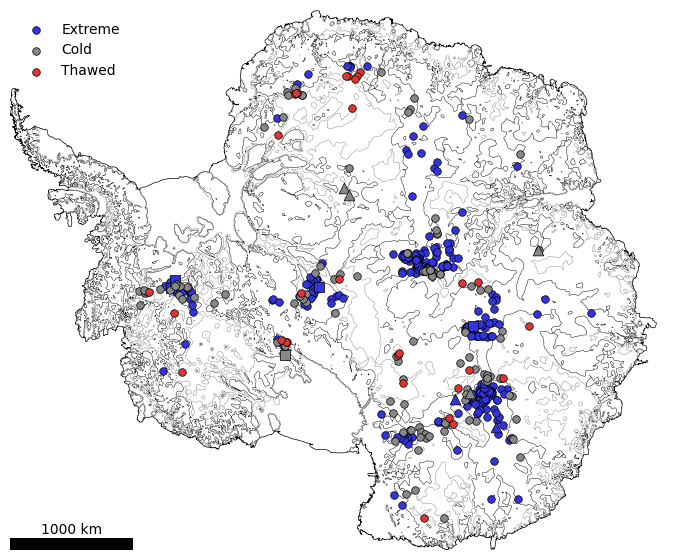

In [19]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='w')

# # Thermal state
# pc = ax.pcolormesh(x, y, Tm, vmin=-20, vmax=0, cmap=cmocean.cm.ice)
# cb = fig.colorbar(pc)
# cb.set_label('Temperature relative to pressure-melting ($^\circ$C)')

conf_colors = {
    'Thawed':'#dd3434',
    'Cold':'#888888',
    'Extreme':'#3434dd'
}

# Grounding line and coastline
# for gl in antarctic_gl.geoms:
#     ax.plot(gl.exterior.coords.xy[0], gl.exterior.coords.xy[1], color=colors['grounding_line'], linewidth=0.5)
ax.plot(antarctic_cl.exterior.coords.xy[0], antarctic_cl.exterior.coords.xy[1], 
        color=colors['grounding_line'], linewidth=0.5)

ax.contour(x, y, BasalTemp, levels=(-10, -1), colors=['k', '#888888'], linewidths=0.33)

# ax.contour(x, y, BasalTemp, levels=(-10,), colors=['k'], linewidths=0.33, linestyles='solid')
# print(BasalTemp)

# Lake inventory
lakes_categories = ['Extreme', 'Cold', 'Thawed']
for category in lakes_categories:
    RES_subset = RES_only_lakes.where(RES_only_lakes['BasalTemp_cat']==category)
    ax.scatter(RES_subset['x'], RES_subset['y'], size['RES_only'], label=category, 
               color=conf_colors[category], marker=markers['RES_only'],
              edgecolor='k', linewidth=0.5, zorder=5)
    
    flat_subset = RES_flat_lakes.where(RES_flat_lakes['BasalTemp_cat']==category)
    ax.scatter(flat_subset['x'], flat_subset['y'], size['RES_flat'], 
               color=conf_colors[category], marker=markers['RES_flat'],
              edgecolor='k', linewidth=0.5, zorder=5)
    
    
    seismic_subset = seismic_lakes.where(seismic_lakes['BasalTemp_cat']==category)
    ax.scatter(seismic_subset['x'], seismic_subset['y'], size['seismic'], 
               color=conf_colors[category], marker=markers['seismic'],
              edgecolor='k', linewidth=0.5, zorder=5)

# Axes controls
ax.set_aspect('equal')
ax.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper left', frameon=False, markerscale=1)

# Scalebar
gl_bounds = antarctic_gl.bounds
scale_width = 1e6
scale_height = 0.1e6
scalebar = patches.Rectangle((gl_bounds[0], gl_bounds[1]), scale_width, scale_height, facecolor='k')
ax.add_patch(scalebar)
ax.text(gl_bounds[0] + 0.5*scale_width, gl_bounds[1] + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center')

fig.subplots_adjust(left=0.05, right=1., bottom=0.05, top=0.95)
fig.savefig('antarctic_thermal_cat_lakes_separated.png', dpi=600)

### Combined plot of modelled basal temperature and lake classifications

(-2508074.680726347, -2143924.7933013136, 2675676.101441902, 2190324.7645620583)


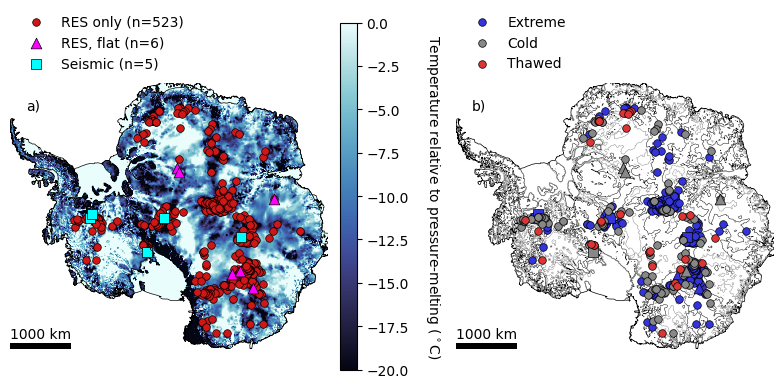

In [86]:
fig = plt.figure(figsize=(8, 3.75), facecolor='w')
gs = GridSpec(3, 5, left=0.01, bottom=0.025, right=0.99, top=0.95,
    wspace=0.025, width_ratios=(100, 5, 25, 100, 0), height_ratios=(15, 100, 0))
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,3])
axs = np.array([ax1, ax2])
cax1 = fig.add_subplot(gs[:, 1])

# Thermal state
pc = ax1.pcolormesh(x, y, BasalTemp, vmin=-20, vmax=0, cmap=cmocean.cm.ice)
cb = fig.colorbar(pc, cax=cax1)
cb.set_label('Temperature relative to pressure-melting ('r'$^\circ$C)', rotation=-90, labelpad=24)

# Grounding line and coastline
for gl in antarctic_gl.geoms:
    ax1.plot(gl.exterior.coords.xy[0], gl.exterior.coords.xy[1], color=colors['grounding_line'], linewidth=0.5)
ax1.plot(antarctic_cl.exterior.coords.xy[0], antarctic_cl.exterior.coords.xy[1], color=colors['coastline'], linewidth=0.5)

# Lake inventory
# lakes_categories = stable_lakes['obs'].values.categories
lakes_categories = ['RES_only', 'RES_flat', 'seismic']
for category in lakes_categories:
    if category!='active':
        lakes_subset = stable_lakes.where(stable_lakes['obs']==category)
        ax1.scatter(lakes_subset['x'], lakes_subset['y'], size[category],
                   color=colors[category], edgecolor=edgecolor[category], linewidth=0.5, 
                   label=labels[category] + ' (n={:n})'.format(lake_counts[category]), 
                   marker=markers[category])

# Axes controls
ax1.set_aspect('equal')
ax1.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([gl_bounds[0], gl_bounds[2]])
ax1.set_ylim([gl_bounds[1], gl_bounds[3]])
# ax1.legend(loc='upper left', frameon=False, markerscale=1)
ax1.legend(bbox_to_anchor=(0, 1., 0.25, 0.5), frameon=False, markerscale=1, loc='lower left')
ax1.text(0.05, 0.9, 'a)', transform=ax1.transAxes)

# Scalebar
gl_bounds = antarctic_gl.bounds
print(gl_bounds)
scale_width = 1e6
scale_height = 0.1e6
scalebar = patches.Rectangle((gl_bounds[0], gl_bounds[1]), scale_width, scale_height, facecolor='k')
ax1.add_patch(scalebar)
ax1.text(gl_bounds[0] + 0.5*scale_width, gl_bounds[1] + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center', va='bottom')


conf_colors = {
    'Thawed':'#dd3434',
    'Cold':'#888888',
    'Extreme':'#3434dd'
}

# Grounding line and coastline
# for gl in antarctic_gl.geoms:
#     ax.plot(gl.exterior.coords.xy[0], gl.exterior.coords.xy[1], color=colors['grounding_line'], linewidth=0.5)
ax2.plot(antarctic_cl.exterior.coords.xy[0], antarctic_cl.exterior.coords.xy[1], 
        color=colors['grounding_line'], linewidth=0.5)

ax2.contour(x, y, BasalTemp, levels=(-10, -1), colors=['k', '#888888'], linewidths=0.33)

# ax.contour(x, y, BasalTemp, levels=(-10,), colors=['k'], linewidths=0.33, linestyles='solid')
# print(BasalTemp)

# Lake inventory
lakes_categories = ['Extreme', 'Cold', 'Thawed']
for category in lakes_categories:
    RES_subset = RES_only_lakes.where(RES_only_lakes['BasalTemp_cat']==category)
    ax2.scatter(RES_subset['x'], RES_subset['y'], size['RES_only'], label=category, 
               color=conf_colors[category], marker=markers['RES_only'],
              edgecolor='k', linewidth=0.5, zorder=5)
    
    flat_subset = RES_flat_lakes.where(RES_flat_lakes['BasalTemp_cat']==category)
    ax2.scatter(flat_subset['x'], flat_subset['y'], size['RES_flat'], 
               color=conf_colors[category], marker=markers['RES_flat'],
              edgecolor='k', linewidth=0.5, zorder=5)
    
    
    seismic_subset = seismic_lakes.where(seismic_lakes['BasalTemp_cat']==category)
    ax2.scatter(seismic_subset['x'], seismic_subset['y'], size['seismic'], 
               color=conf_colors[category], marker=markers['seismic'],
              edgecolor='k', linewidth=0.5, zorder=5)

# Axes controls
ax2.set_aspect('equal')
ax2.spines[['left', 'right', 'bottom', 'top']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
# ax2.legend(loc='upper left', frameon=False, markerscale=1)
ax2.legend(bbox_to_anchor=(0, 1., 0.25, 0.5), frameon=False, markerscale=1, loc='lower left')

# Scalebar
gl_bounds = antarctic_gl.bounds
scale_width = 1e6
scale_height = 0.1e6
scalebar = patches.Rectangle((gl_bounds[0], gl_bounds[1]), scale_width, scale_height, facecolor='k')
ax2.add_patch(scalebar)
ax2.text(gl_bounds[0] + 0.5*scale_width, gl_bounds[1] + 1.25*scale_height, '{:d} km'.format(int(scale_width/1e3)),
        ha='center', va='bottom')
ax2.text(0.05, 0.9, 'b)', transform=ax2.transAxes)

ax2.set_xlim([gl_bounds[0], gl_bounds[2]])
ax2.set_ylim([gl_bounds[1], gl_bounds[3]])

fig.savefig('antarctic_thermal_lakes_merged_cat_conf.png', dpi=400)